# Spectrum model

#### Assumption 
- **single burst** @ t = 0 (no star formation)
- $M_\text{min} = 0.1 M_\odot$ , $M_\text{max} (t= 0) = 100 M_\odot$
- After the ZAMS star turn off 
- star emitt as a perfect BB (no absorbtion lines in the atmosphere)
- No emission line from ISM (Interstellar Medium)
- No dust
- $ dN /dm(t = 0) = \xi m^{-2.35}$, **Salpeter initial mass function**

The only relevant paramters are: Mass, Metallicity $\left( M , Z \right)$ (All the scale relation are given by stellar model). We assume the effect of metallicity negligible 

Given a certain mass the model gives back a spectrum, we compare it with the real data and we try to guess the age and the total mass of the galaxy (Rule of thumb)

N.B. For "total mass" we are not considering the total "baryonic" or "dynamical" mass, but only the "bright" mass (which show EM features)

### How to improve the model
- Using strectrum templates to find di $H\alpha$ line. Use a Gaussian or Lorentzian distruibution to model the emission line and find the centroid
- Take into account star formation, dust and metallicity. 
    - Star formation: $\dot{m}_{gal} \propto \exp(-t/\tau)$
    - Dust: $f_{obs}(\lambda) = f_{int} (\lambda) 10^{0.44 K(\lambda)} $, $K(\lambda)$ is Calzetti function
    - Metallicity: see : https://iopscience.iop.org/article/10.1086/379506/pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.modeling.models import BlackBody
from IPython.display import HTML
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from specutils import Spectrum1D
from astropy import units as u
from astropy.cosmology import WMAP5
from astropy.cosmology import Planck18 as cosmo
#config plot
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)
%config InlineBackend.figure_format='retina'

In [2]:
# constants
L_solar = 3.8 * 10**33 * u.erg / u.s # solar luminosity in erg s-1
M_solar = 1.989 * 10**33 * u.g # solar mass in g
T_solar = 5780 * u.K # surface solar temperature in K
lambHa = 6562.81 * u.AA # wavelenght H\alpha emission line in A°

# Assumptions  of the model
M_min = 0.1 # minimum mass in solar masses
M_max = 100 # maximum mass in solar masses
nbin = 1000 # mass binning
alpha = 2.35 # exponent  IMF (Initial Mass Function)
n_T = 0.5 # exponent scale relation M - T
n_L = 3 # exponent scale relation M - L

# global data structure 
lambd = np.arange(int(1e3) ,int(1e4), 10) # wavelenght vector in Angstrom
m_arr = np.linspace(M_min,M_max, nbin)  # masses vector in unit of solar masses

#  Define the model 

In [3]:
# Given a certain age and total mass, the model gives back a continuim spectrum 
def spmodel(M_tot, age_g):
    '''
     M_tot in solar masses
     age_g in solar lifetime
    '''
    bb_arr = np.array([])
    bb_tot = 0
    xi = M_tot * (2 - alpha) / (M_max **(2-alpha) - M_min **(2- alpha)) # normalization constant IMF
    global lamd, m_arr
    
    for m in m_arr:
        T = T_solar * (m** n_T )
        L = L_solar * (m)** n_L
        nstars = xi *  m**(- alpha)
        lifetime_s = m * M_solar.value / L.value
        if age_g <= lifetime_s:
            b0 = BlackBody(temperature=T, scale = 1.*u.erg/(u.cm**2 * u.AA * u.s * u.sr))
            bb = L*nstars*b0(lambd * u.AA).value/(b0.bolometric_flux.value)
            bb_tot += bb
        else:
            break
    return bb_tot

# Open data S1

z =  0.019084375276177346


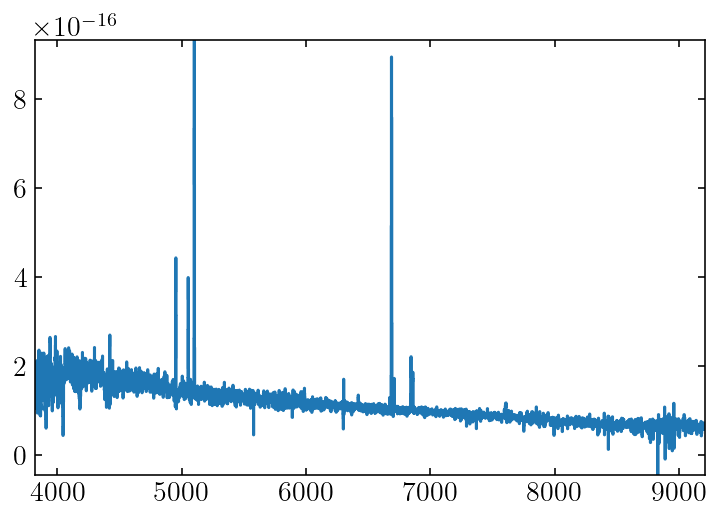

In [4]:
#open file fits and read data
hdulist = fits.open('S1.fits')
#hdulist.info() 
flux_1 = hdulist[1].data['flux']*10**(-17) * u.Unit('erg cm-2 s-1 AA-1') 
lamb_1 = 10**hdulist[1].data['loglam'] * u.AA
#plot spectrum
spec = Spectrum1D(spectral_axis= lamb_1, flux=flux_1) 
f, ax = plt.subplots()  
ax.step(spec.spectral_axis, spec.flux) 
#compute the redshift and shift the spectrum
z = lamb_1[flux_1[2000:3000].argmax()+2000] / (lambHa) - 1
lum_dist_1 = cosmo.luminosity_distance(z).to(u.cm)
Luminosity_1 = flux_1 * (4 * np.pi * (1 + z) * lum_dist_1**2)
rf_lamb_1 = lamb_1 / (1+z)
print('z = ',z)

# Model for S1

The peak of the spectrum is at 3740 A˚


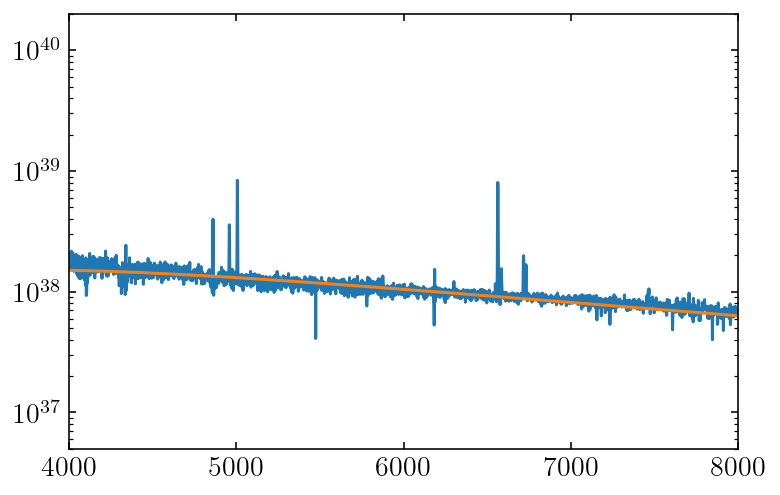

In [22]:
y = spmodel(M_tot= 4.8*10**7, age_g=0.07 )
plt.plot(rf_lamb_1, Luminosity_1)
plt.plot(lambd, y)

plt.yscale("log")
plt.xlim(4000, 8000)
plt.ylim(5e36,2e40)
max_l = lambd[np.argmax(y)]
plt.axvline(max_l, color = 'red', linestyle = 'dashed', lw = .8)


print('The peak of the spectrum is at', max_l, 'A˚')

# Open data S2

z = 0.07847524535983808


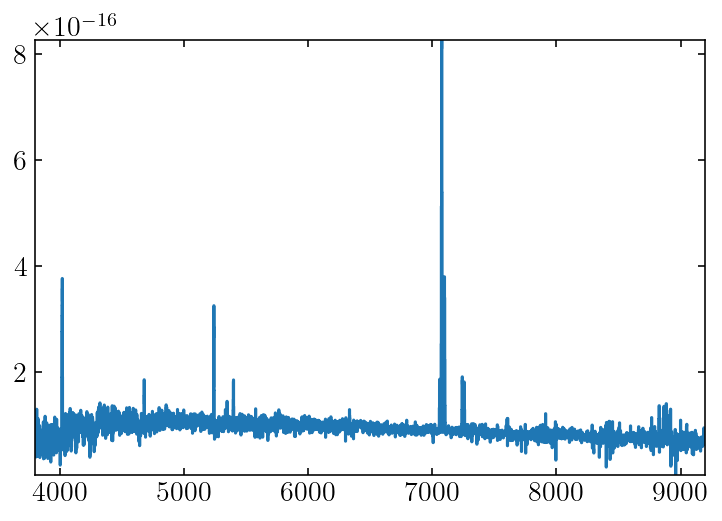

In [23]:
hdulist = fits.open('S2.fits')
#hdulist.info() 
flux_2 = hdulist[1].data['flux']*10**(-17) * u.Unit('erg cm-2 s-1 AA-1') 
lamb_2 = 10**hdulist[1].data['loglam'] * u.AA
spec = Spectrum1D(spectral_axis= lamb_2, flux=flux_2) 
f, ax = plt.subplots()  
ax.step(spec.spectral_axis, spec.flux) 
z = lamb_2[flux_2.argmax()] / (lambHa) - 1
lum_dist = cosmo.luminosity_distance(z).to(u.cm)
Luminosity_2 = flux_2 * (4 * np.pi * (1 + z) * lum_dist**2)
rf_lamb_2 = lamb_2 / (1+z)
print('z =',z)

# Model for S2

The peak of the spectrum is at 4980 A˚


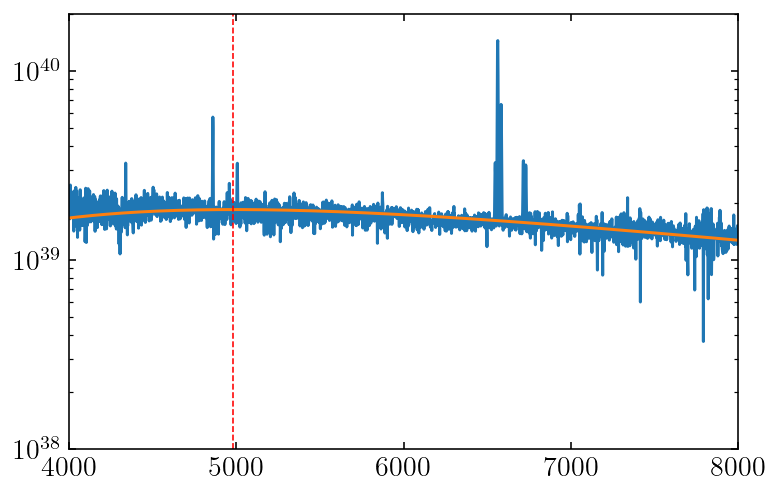

In [24]:
y = spmodel(M_tot= 2*10**9, age_g=0.23 )
plt.plot(rf_lamb_2, Luminosity_2)
plt.plot(lambd, y)

plt.yscale("log")
plt.xlim(4000, 8000)
plt.ylim(1e38,2e40)
max_l = lambd[np.argmax(y)]
plt.axvline(max_l, color = 'red', linestyle = 'dashed', lw = .8)


print('The peak of the spectrum is at', max_l, 'A˚')

# Open Data S3

z = 0.09247160800785026


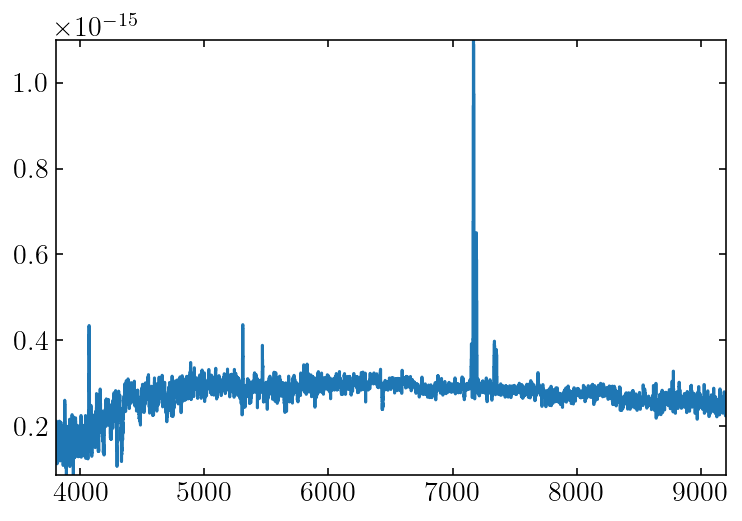

In [25]:
#open data from fits file
hdulist = fits.open('S3.fits')
#hdulist.info() 
flux_3 = hdulist[1].data['flux']*10**(-17) * u.Unit('erg cm-2 s-1 AA-1') 
lamb_3 = 10**hdulist[1].data['loglam'] * u.AA
#plot the spectrum 
spec = Spectrum1D(spectral_axis= lamb_3, flux=flux_3) 
f, ax = plt.subplots()  
ax.step(spec.spectral_axis, spec.flux) 
# compute the redshift and the luminosity distance to shift the spectrum
z = lamb_3[flux_3.argmax()] / (lambHa) - 1
lum_dist = cosmo.luminosity_distance(z).to(u.cm)
Luminosity_3 = flux_3 * (4 * np.pi * (1 + z) * lum_dist**2)
rf_lamb_3 = lamb_3 / (1+z)
print('z =',z)

The peak of the spectrum is at 5550 A˚


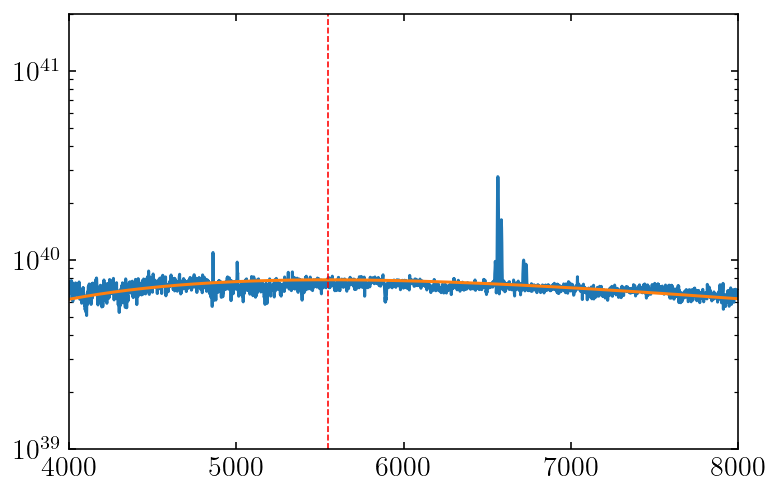

In [26]:
y = spmodel(M_tot= 1.35*10**10, age_g= 0.35)
plt.plot(rf_lamb_3, Luminosity_3)
plt.plot(lambd, y)

plt.yscale("log")
plt.xlim(4000, 8000)
plt.ylim(1e39,2e41)
max_l = lambd[np.argmax(y)]
plt.axvline(max_l, color = 'red', linestyle = 'dashed', lw = .8)


print('The peak of the spectrum is at', max_l, 'A˚')

# Open data S4

'\nproblem:  How to compute the redshift ?\n\n'

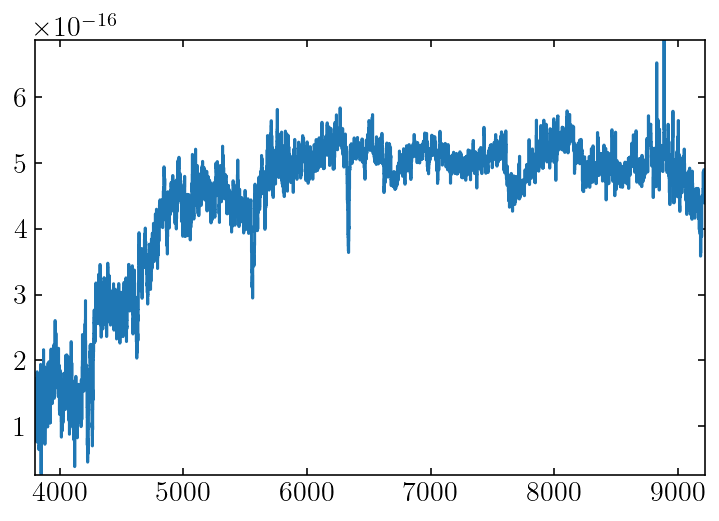

In [27]:
#open data from fits file
hdulist = fits.open('S4.fits')
#hdulist.info() 
flux_4 = hdulist[1].data['flux']*10**(-17) * u.Unit('erg cm-2 s-1 AA-1') 
lamb_4 = 10**hdulist[1].data['loglam'] * u.AA
#plot the spectrum 
spec = Spectrum1D(spectral_axis= lamb_4, flux=flux_4) 
f, ax = plt.subplots()  
ax.step(spec.spectral_axis, spec.flux) 
# compute the redshift and the luminosity distance to shift the spectrum
'''
problem:  How to compute the redshift ?

'''
